In [15]:
import numpy as np
from qiskit.circuit.library import RXGate, RZGate, RXXGate
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

class LineEntanglingLayerBuilder:
    """
    Build entangling layers according to the line topology.
    The 1st qubit will entangle with the 2nd, 2nd with 3rd, and so on.
    """

    def __init__(self, n_qubits: int):
        """Entangler according to the line topology.

        Args:
            n_qubits: number of qubits in the circuit.
        """
        self.n_qubits = n_qubits
        self.adjacency_matrix = np.zeros((n_qubits, n_qubits), dtype=np.int8)
        
        for i in range(n_qubits - 1):
            self.adjacency_matrix[i][i + 1] = self.adjacency_matrix[i + 1][i] = 1

    def build_layer(self, params, gate=RXXGate,use_rxx=True):
        """Builds the entangling layer with the given gate and parameters."""
        layer = []
        param_idx = 0
        for i in range(self.n_qubits - 1):
            if use_rxx:
                layer.append((gate(params[param_idx]), i, i + 1))
            else:
                layer.append((params[param_idx], i, i + 1))
            param_idx += 1
        return layer
    

class EntanglingLayerAnsatz:
    def __init__(self, n_qubits: int, n_layers: int, entangling_layer_builder: LineEntanglingLayerBuilder, use_rxx = True):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.entangling_layer_builder = entangling_layer_builder
        self.use_rxx = use_rxx

    @property
    def number_of_params(self) -> int:
        return 2 * self.n_qubits * self.n_layers + (self.n_qubits - 1) * self.n_layers

    @property
    def number_of_qubits(self) -> int:
        return self.n_qubits

    def get_executable_circuit(self, params):
        circuit = QuantumCircuit(self.n_qubits)
        param_idx = 0
        if self.use_rxx:
            for layer_idx in range(self.n_layers):
                # Apply RX and RZ gates
                for qubit in range(self.n_qubits):
                    circuit.append(RXGate(params[param_idx]), [qubit])
                    param_idx += 1
                    circuit.append(RZGate(params[param_idx]), [qubit])
                    param_idx += 1
                # Apply entangling layer
                entangling_layer = self.entangling_layer_builder.build_layer(params[param_idx:], RXXGate)
                for gate, qubit1, qubit2 in entangling_layer:
                    circuit.append(gate, [qubit1, qubit2])
                param_idx += self.n_qubits - 1
            circuit.measure_all()
        else:
            for layer_idx in range(self.n_layers):
                # Apply RX and RZ gates
                for qubit in range(self.n_qubits):
                    circuit.append(RXGate(params[param_idx]), [qubit])
                    param_idx += 1
                    circuit.append(RZGate(params[param_idx]), [qubit])
                    param_idx += 1
                # Apply entangling layer
                entangling_layer = self.entangling_layer_builder.build_layer(params[param_idx:],use_rxx=False)
                for theta, qubit1, qubit2 in entangling_layer:
                    circuit.cx(qubit1, qubit2)
                    circuit.rz(2 * theta, qubit2)
                    circuit.cx(qubit1, qubit2)
                param_idx += self.n_qubits - 1
            circuit.measure_all()
        return circuit

    def draw_circuit(self):
        params = [Parameter(f'theta_{i}') for i in range(self.number_of_params)]
        circuit = self.get_executable_circuit(params)
        return circuit.draw(output='mpl')


In [21]:
import torch
import numpy as np

class ExactNLLTorch:
    def __call__(self, true_probs: np.ndarray, pred_probs: np.ndarray) -> float:
        # Convert numpy arrays to PyTorch tensors and move them to the appropriate device
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        epsilon = 1e-10
        true_probs_torch = torch.from_numpy(true_probs).float().to(device)
        pred_probs_torch = torch.from_numpy(pred_probs).float().to(device)

        # Clip probabilities to avoid log(0)
        pred_probs_torch = torch.clamp(pred_probs_torch, min=epsilon)

        # Compute negative log likelihood
        nll = -torch.sum(true_probs_torch * torch.log(pred_probs_torch))

        # Move the result back to CPU and convert to python float for further usage
        return nll.cpu().item()

In [11]:
from scipy.optimize import minimize

class ScipyOptimizer:
    def __init__(self, method='COBYLA', options=None):
        self.method = method
        self.options = options if options else {}

    def minimize(self, loss_fn, initial_params):
        result = minimize(loss_fn, initial_params, method=self.method, options=self.options)
        return result


In [52]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler
from qiskit import transpile
import numpy as np
import json


class SingleBasisQCBM:
    def __init__(self, ansatz, optimizer, distance_measure=None, choices=(-1.0, 1.0), param_initializer=None):
        self.ansatz = ansatz
        self.optimizer = optimizer
        self.num_qubits = ansatz.number_of_qubits
        self.distance_measure = distance_measure if distance_measure else self._default_distance_measure
        self.choices = choices
        self.params = self._get_initial_parameters(param_initializer)

    def _default_distance_measure(self, target_probs, model_probs):
        epsilon = 1e-10
        return np.sum(target_probs * np.log(target_probs / (model_probs + epsilon) + epsilon))

    def _get_initial_parameters(self, initializer):
        if np.any(initializer):
            return initializer
        return np.random.uniform(-np.pi / 2, np.pi / 2, self.ansatz.number_of_params)

    def _get_model_object(self, parameters, sampler, backend):
        qc = self.ansatz.get_executable_circuit(parameters)
        qc_transpiled = transpile(qc, backend)
        job = sampler.run(circuits=[qc_transpiled])
        result = job.result()
        quasi_dist = result.quasi_dists[0]
        counts = quasi_dist.binary_probabilities()
        shots = sum(counts.values())
        probs = np.array([counts.get(f"{i:0{self.num_qubits}b}", 0) / shots for i in range(2**self.num_qubits)])
        return probs

    def _get_generator_fn(self, sampler, backend, random_seed=None):
        def generator(n_samples, parameters):
            qc = self.ansatz.get_executable_circuit(parameters)
            qc_transpiled = transpile(qc, backend)
            job = sampler.run(circuits=[qc_transpiled])
            result = job.result()
            quasi_dist = result.quasi_dists[0]
            counts = quasi_dist.binary_probabilities()
            samples = np.array([list(map(int, k)) for k, v in counts.items() for _ in range(int(v * n_samples))])
            return samples
        return generator

    def train_on_batch(self, X, Y, sampler, backend, n_epochs):
        target_probs = np.zeros(2**self.num_qubits)
        for x, y in zip(X, Y):
            index = int("".join(map(str, x)), 2)
            target_probs[index] = y

        for epoch in range(n_epochs):
            def loss_fn(parameters):
                model_probs = self._get_model_object(parameters, sampler, backend)
                return self.distance_measure(target_probs, model_probs)

            result = self.optimizer.minimize(loss_fn, self.params)
            self.params = result.x
        return result

    def generate(self, num_samples, sampler, backend):
        generator = self._get_generator_fn(sampler, backend)
        samples = generator(num_samples, self.params)
        unique_samples, counts = np.unique(samples, axis=0, return_counts=True)
        probabilities = counts / num_samples
        return unique_samples, probabilities

    def save_params(self, filename):
        with open(filename, 'w') as f:
            json.dump(self.params.tolist(), f)

    def load_params(self, filename):
        with open(filename, 'r') as f:
            self.params = np.array(json.load(f))



In [55]:
import numpy as np
from itertools import combinations
import random

def generate_data(num_qubits, cardinality, num_samples):
    # Generate all possible binary vectors of length num_qubits with the given cardinality
    vectors = list(combinations(range(num_qubits), cardinality))
    
    # Convert combinations to binary vectors
    X = []
    for vec in vectors:
        binary_vec = [0] * num_qubits
        for idx in vec:
            binary_vec[idx] = 1
        X.append(binary_vec)
    
    # If the number of samples is less than the number of possible vectors, randomly sample
    if num_samples < len(X):
        X = random.sample(X, num_samples)
    
    # Generate random probabilities for each binary vector
    Y = np.random.uniform(0, 1, len(X))
    
    # Normalize probabilities to sum to 1
    Y = Y / np.sum(Y)
    
    return np.array(X), Y

num_qubits = 10
cardinality = 5
num_samples = 500

X, Y = generate_data(num_qubits, cardinality, num_samples)

# Print some examples of the generated data
print("Example X:", X[:5])
print("Example Y:", Y[:5])

Example X: [[1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 0 1 0 0 0 0]
 [1 1 1 1 0 0 1 0 0 0]
 [1 1 1 1 0 0 0 1 0 0]
 [1 1 1 1 0 0 0 0 1 0]]
Example Y: [0.00361798 0.00139656 0.00572912 0.00658601 0.00573242]


In [59]:

# Initialize Qiskit Runtime Service with specific credentials
service = QiskitRuntimeService(name="ibm_uoft")
backend = service.backend("ibm_quebec")  # Using IBM Quebec backend

# num_qubits = 4
depth = 3
# X = np.array([[1, 1, 1,1], [0, 1, 0,0],[0, 1, 1,0], [0, 0, 0,0], [0, 0, 1,0]])
# Y = np.array([0.2, 0.2,0.2,0.2,0.2])

entangling_layer_builder = LineEntanglingLayerBuilder(num_qubits)
ansatz = EntanglingLayerAnsatz(num_qubits, depth, entangling_layer_builder,use_rxx=False)

options = {
    'maxiter': 10,   # Maximum number of iterations
    'tol': 1e-6,      # Tolerance for termination
    'disp': True      # Display convergence messages
}
#Powell
optimizer = ScipyOptimizer(method='COBYLA', options=options)

qcbm = SingleBasisQCBM(ansatz, optimizer,distance_measure=ExactNLLTorch())


qcbm.load_params('qcbm_params.json')
# trained_param = qcbm.params.copy()
# qcbm = SingleBasisQCBM(ansatz, optimizer,distance_measure=ExactNLLTorch(),param_initializer=trained_param)


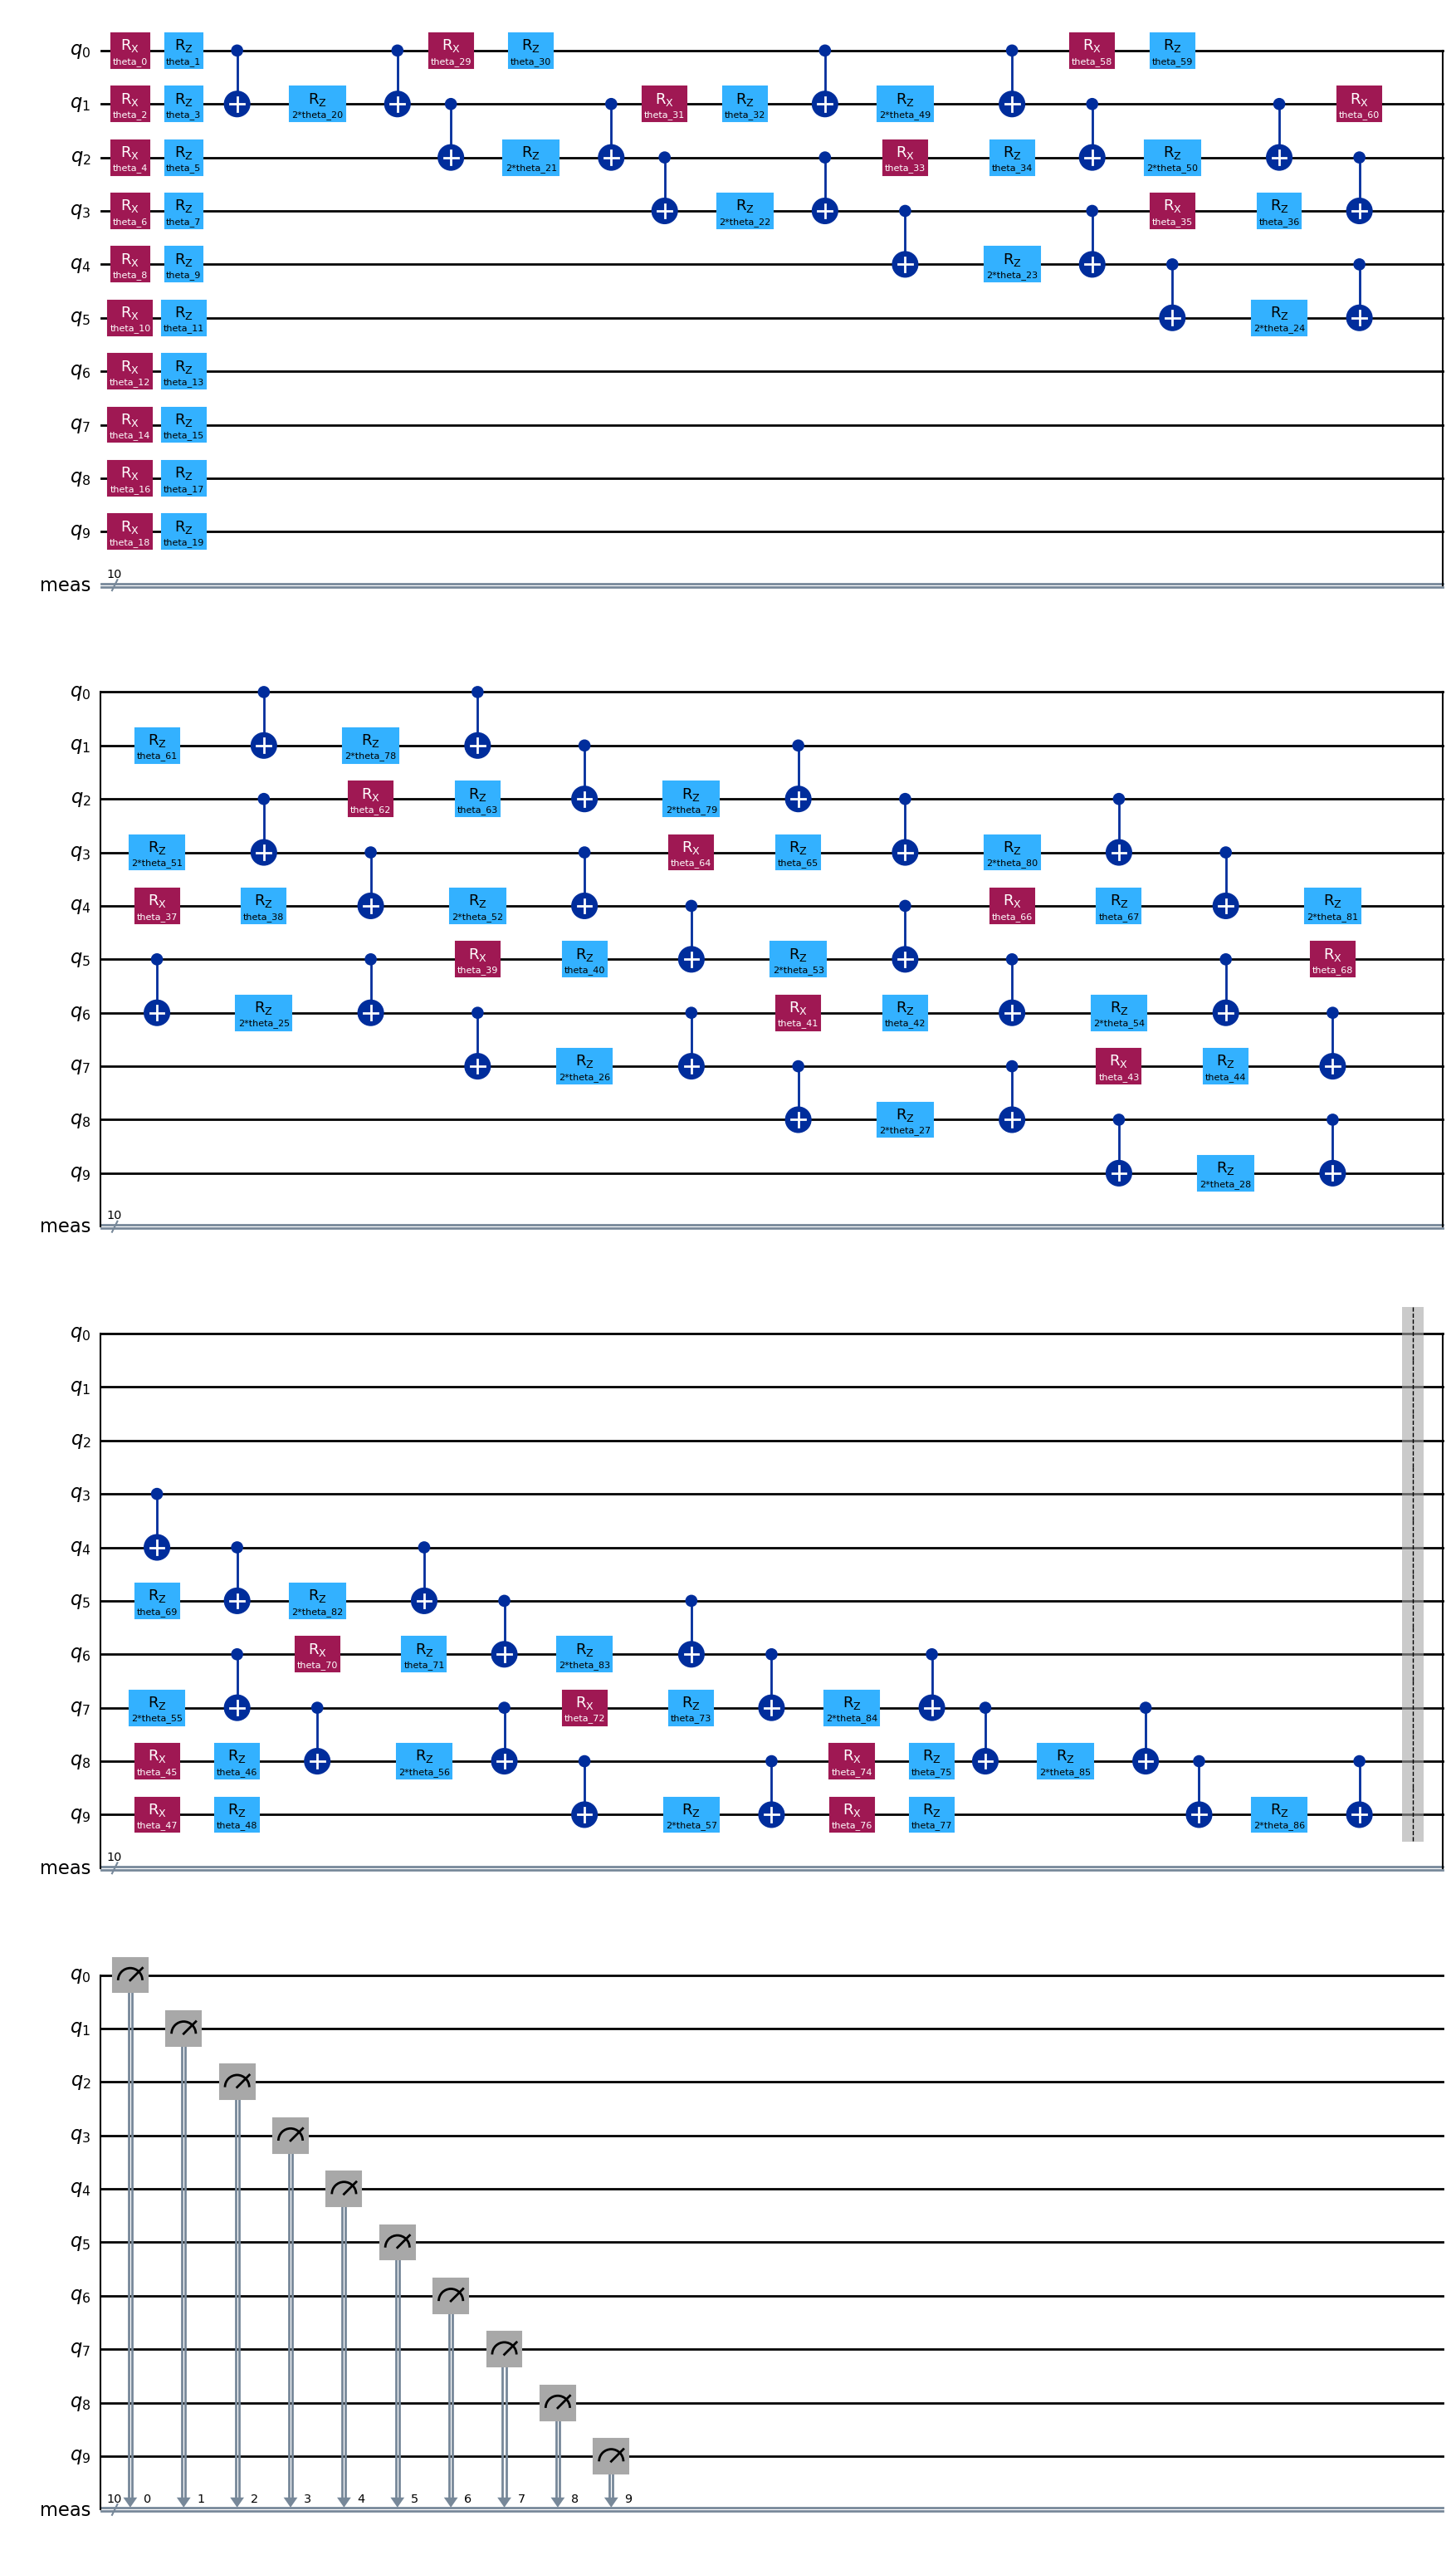

In [58]:
ansatz.draw_circuit()

In [60]:

# Start a session
n_epochs = 100
with Session(service=service, backend=backend) as session:
    sampler = Sampler(session=session)
    result = qcbm.train_on_batch(X, Y, sampler, backend, n_epochs)
    num_samples = 1000
    unique_samples, probabilities = qcbm.generate(num_samples, sampler, backend)
    qcbm.save_params("hw_param_train_10_qubits_3_layer_linear.json")
    for sample, prob in zip(unique_samples, probabilities):
        print(f"Sample: {sample}, Probability: {prob}")



/var/folders/01/9cxlhzln35j3j4d6wdv8jmmw0000gp/T/ipykernel_32674/1817558399.py:4: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(session=session)
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
Traceback (most recent call last):
  File "/Users/mohamad/miniconda3/envs/qcbm-ibmq/lib/python3.11/site-packages/scipy/optimize/_cobyla_py.py", line 281, in calcfc
    f = sf.fun(x)
        ^^^^^^^^^
  File "/Users/mohamad/miniconda3/envs/qcbm-ibmq/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 278, in fu

: 

In [26]:
for sample, prob in zip(unique_samples, probabilities):
    print(f"Sample: {sample}, Probability: {prob}")

Sample: [0 0 0 0], Probability: 0.081
Sample: [0 0 0 1], Probability: 0.107
Sample: [0 0 1 0], Probability: 0.031
Sample: [0 0 1 1], Probability: 0.02
Sample: [0 1 0 0], Probability: 0.202
Sample: [0 1 0 1], Probability: 0.198
Sample: [0 1 1 0], Probability: 0.085
Sample: [0 1 1 1], Probability: 0.03
Sample: [1 0 0 0], Probability: 0.016
Sample: [1 0 0 1], Probability: 0.019
Sample: [1 0 1 0], Probability: 0.006
Sample: [1 0 1 1], Probability: 0.002
Sample: [1 1 0 0], Probability: 0.068
Sample: [1 1 0 1], Probability: 0.062
Sample: [1 1 1 0], Probability: 0.039
Sample: [1 1 1 1], Probability: 0.025


In [ ]:
# X = np.array([[1, 1, 1,1], [0, 1, 0,0],[0, 1, 1,0], [0, 0, 0,0], [0, 0, 1,0]])
# Y = np.array([0.2, 0.2,0.2,0.2,0.2])

In [29]:
qcbm.save_params("param_4_4.json")

In [30]:
qcbm.load_params("param_4_4.json")

ADD 
1. loss comparison plot
2. error mitigation
3. add simulator 